# GAVD Exploration Notebook

@Author: Alex Mui
@Email: jiamingmui@gmail.com

In [1]:
import sys
from pathlib import Path
import pandas as pd
from typing import Dict, List

In [2]:
project_root = Path.cwd().parent

# Add the project root to the Python path
sys.path.insert(0, str(project_root))
print(f"Project root: {project_root}")

Project root: c:\Users\alexm\projects\alex\alexpose


In [3]:
from ambient.utils.csv_parser import parse_csv_with_dicts
from ambient.gavd import GaitDataProcessor, GAVDDataLoader, PoseDataConverter
from ambient.gavd.pose_estimators import OpenPoseEstimator

## Step 1: Load Sequences of GAVD Data

In [ ]:
ONE_SEQUENCE_PATH = Path(project_root, "data", "GAVD_Clinical_Annotations_1.1.csv")

In [5]:
loader = GAVDDataLoader()
df = loader.load_gavd_data(ONE_SEQUENCE_PATH)
sequences = loader.organize_by_sequence(df)
len(sequences)

2025-12-29 20:26:11.865 | INFO     | ambient.gavd.gavd_processor:load_gavd_data:342 - Loading GAVD data from: c:\Users\alexm\projects\alex\alexpose\data\GAVD_Clinical_Annotations_1_simple.csv
2025-12-29 20:26:11.908 | WARNING  | ambient.gavd.gavd_processor:_download_youtube_videos:290 - YouTube cookies file not found at c:\Users\alexm\projects\alex\alexpose\config\yt_cookies.txt
2025-12-29 20:26:12.064 | INFO     | ambient.utils.youtube_cache:_prepare_download_list:227 - Already cached (skipping): C:\Users\alexm\projects\alex\alexpose\data\youtube\B5hrxKe2nP8.mp4
2025-12-29 20:26:12.074 | INFO     | ambient.gavd.gavd_processor:_log_loading_statistics:410 - Loaded 727 rows with 2 unique sequences
2025-12-29 20:26:12.075 | INFO     | ambient.gavd.gavd_processor:_log_loading_statistics:413 - Columns: ['seq', 'frame_num', 'cam_view', 'gait_event', 'dataset', 'gait_pat', 'bbox', 'vid_info', 'id', 'url', '_processed_at', '_source_file']
2025-12-29 20:26:12.076 | INFO     | ambient.gavd.gavd_

YouTube cache attempted: 1
YouTube cache skipped: 1
YouTube cache downloaded: 0
YouTube cache failed: 0


2

In [6]:
type(sequences)

dict

In [7]:
sequences.keys()

dict_keys(['cljan9b4p00043n6ligceanyp', 'cljanb45y00083n6lmh1qhydd'])

## Step 2: Analyze Sequence Structure

In [8]:
def analyze_sequence_structure(sequences: Dict[str, pd.DataFrame]):
    """
    Analyze the structure of sequences to understand the data organization.
    
    Args:
        sequences (Dict[str, pd.DataFrame]): Organized sequence data
    """
    print("\n" + "="*50)
    print("SEQUENCE STRUCTURE ANALYSIS")
    print("="*50)
    
    for seq_id, seq_data in sequences.items():
        print(f"\nSequence: {seq_id}")
        print(f"  Total frames: {len(seq_data)}")
        print(f"  Frame numbers: {seq_data['frame_num'].tolist()}")
        
        # Show first few frames
        print(f"  First 3 frames:")
        for i, (_, row) in enumerate(seq_data.head(3).iterrows()):
            bbox = row['bbox']
            if isinstance(bbox, dict):
                print(f"    Frame {row['frame_num']}: bbox at ({bbox.get('left', 0):.1f}, {bbox.get('top', 0):.1f})")
        
        # Check if frames are consecutive
        frame_nums = seq_data['frame_num'].astype(int).values
        is_consecutive = all(frame_nums[i+1] - frame_nums[i] == 1 for i in range(len(frame_nums)-1))
        print(f"  Consecutive frames: {is_consecutive}")


In [9]:
analyze_sequence_structure(sequences)


SEQUENCE STRUCTURE ANALYSIS

Sequence: cljan9b4p00043n6ligceanyp
  Total frames: 512
  Frame numbers: [1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 19

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ambient.utils.youtube_cache import extract_video_id
from ambient.gavd import PoseDataConverter

def visualize_frame(sequences: Dict[str, pd.DataFrame], seq_id: str, frame_index: int = 0, show_bbox: bool = True):
    """
    Visualize a specific frame from a sequence with proper bbox alignment.
    
    FIXES APPLIED:
    1. Uses FFmpeg for precise frame extraction (more accurate than OpenCV seeking)
    2. Scales bbox coordinates if video resolution differs from annotation
    3. Validates frame number and video properties
    
    Args:
        sequences: Dictionary of sequences (from organize_by_sequence)
        seq_id: Sequence ID to visualize
        frame_index: Index of the frame within the sequence (0-based)
        show_bbox: Whether to draw the bounding box on the frame
    """
    if seq_id not in sequences:
        print(f"Sequence {seq_id} not found. Available sequences: {list(sequences.keys())}")
        return
    
    seq_data = sequences[seq_id]
    
    if frame_index >= len(seq_data):
        print(f"Frame index {frame_index} out of range. Sequence has {len(seq_data)} frames.")
        return
    
    # Get the frame row
    frame_row = seq_data.iloc[frame_index]
    frame_num = int(frame_row['frame_num'])
    url = frame_row.get('url', '')
    bbox = frame_row.get('bbox', {})
    vid_info = frame_row.get('vid_info', {})
    
    # Extract video ID and find cached video
    video_id = extract_video_id(url) if url else None
    if not video_id:
        print(f"No URL found for frame {frame_index}")
        return
    
    # Look for cached video file
    video_cache_dir = project_root / "data" / "youtube"
    video_path = None
    for ext in ['.mp4', '.webm', '.mkv', '.mov']:
        candidate = video_cache_dir / f"{video_id}{ext}"
        if candidate.exists():
            video_path = candidate
            break
    
    if not video_path:
        print(f"Video not found in cache. Expected: {video_cache_dir / f'{video_id}.mp4'}")
        return
    
    # Get actual video properties
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"Failed to open video: {video_path}")
        return
    
    video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    
    # Validate frame number
    frame_index_0based = frame_num - 1  # Convert 1-based to 0-based
    if frame_index_0based < 0 or frame_index_0based >= video_frame_count:
        print(f"WARNING: Frame {frame_num} is out of video range (0-{video_frame_count-1})")
        print(f"Using frame index {frame_index_0based} (may cause misalignment)")
    
    # Extract frame using FFmpeg for precision (more accurate than OpenCV seeking)
    converter = PoseDataConverter(video_cache_dir=str(video_cache_dir))
    try:
        import tempfile
        import shutil
        temp_img_path = converter._extract_frame_image(video_path, frame_index_0based)
        frame = cv2.imread(str(temp_img_path))
        if frame is None:
            raise ValueError(f"Failed to read extracted frame from {temp_img_path}")
        # Clean up temp file
        temp_dir = temp_img_path.parent
        shutil.rmtree(temp_dir, ignore_errors=True)
    except Exception as e:
        print(f"FFmpeg extraction failed: {e}. Falling back to OpenCV...")
        # Fallback to OpenCV
        cap = cv2.VideoCapture(str(video_path))
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index_0based)
        ret, frame = cap.read()
        cap.release()
        if not ret:
            print(f"Failed to read frame {frame_num} from video")
            return
    
    # Convert BGR to RGB for matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    actual_height, actual_width = frame_rgb.shape[:2]
    
    # Scale bbox coordinates if video resolution differs from annotation
    annotation_width = vid_info.get('width', actual_width)
    annotation_height = vid_info.get('height', actual_height)
    
    if show_bbox and isinstance(bbox, dict):
        # Scale bbox if resolution differs
        if annotation_width != actual_width or annotation_height != actual_height:
            scale_x = actual_width / annotation_width if annotation_width > 0 else 1.0
            scale_y = actual_height / annotation_height if annotation_height > 0 else 1.0
            left = int(bbox.get('left', 0) * scale_x)
            top = int(bbox.get('top', 0) * scale_y)
            width = int(bbox.get('width', 0) * scale_x)
            height = int(bbox.get('height', 0) * scale_y)
            print(f"Scaled bbox: annotation={annotation_width}x{annotation_height}, "
                  f"video={actual_width}x{actual_height}, scale=({scale_x:.3f}, {scale_y:.3f})")
        else:
            left = int(bbox.get('left', 0))
            top = int(bbox.get('top', 0))
            width = int(bbox.get('width', 0))
            height = int(bbox.get('height', 0))
        
        if width > 0 and height > 0:
            # Draw rectangle (frame_rgb is RGB, so (255, 0, 0) is red)
            cv2.rectangle(frame_rgb, (left, top), (left + width, top + height), (255, 0, 0), 2)
            print(f"Bbox drawn: left={left}, top={top}, width={width}, height={height}")
    
    # Display the frame
    plt.figure(figsize=(12, 8))
    plt.imshow(frame_rgb)
    plt.title(f"Sequence: {seq_id}\nFrame: {frame_num} (index {frame_index})\n"
              f"Video: {actual_width}x{actual_height}, Annotation: {annotation_width}x{annotation_height}", 
              fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Displayed frame {frame_num} from sequence {seq_id}")


## Step 3: Visualize Frames


### 3.1  First Sequence

In [11]:
# Example: Visualize a specific frame
# Get the first sequence ID
first_seq_id = list(sequences.keys())[0]
first_frame_num = sequences[first_seq_id]['frame_num'].iloc[0]

In [12]:
# How many frames are in the first sequence?
len(sequences[first_seq_id])

512

Scaled bbox: annotation=1280x720, video=640x360, scale=(0.500, 0.500)
Bbox drawn: left=76, top=62, width=119, height=250


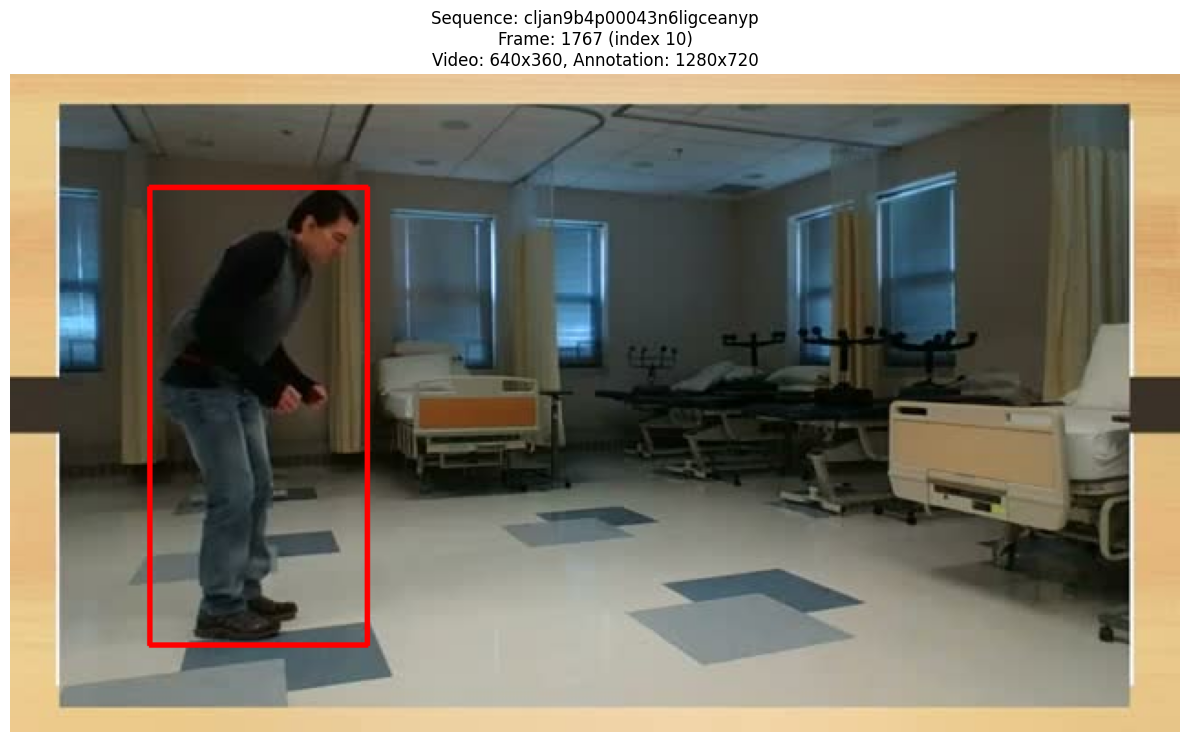

Displayed frame 1767 from sequence cljan9b4p00043n6ligceanyp


In [13]:
# Visualize the frame
# visualize_frame(sequences, first_seq_id, int(first_frame_num), draw_bbox=True)
visualize_frame(sequences, first_seq_id, frame_index=10, show_bbox=True)

### 3.2  Second Sequence

In [14]:
# Example: Visualize a specific frame
second_seq_id = list(sequences.keys())[1]
# How many frames are in the second sequence?
len(sequences[second_seq_id])

215

Scaled bbox: annotation=1280x720, video=640x360, scale=(0.500, 0.500)
Bbox drawn: left=402, top=64, width=123, height=242


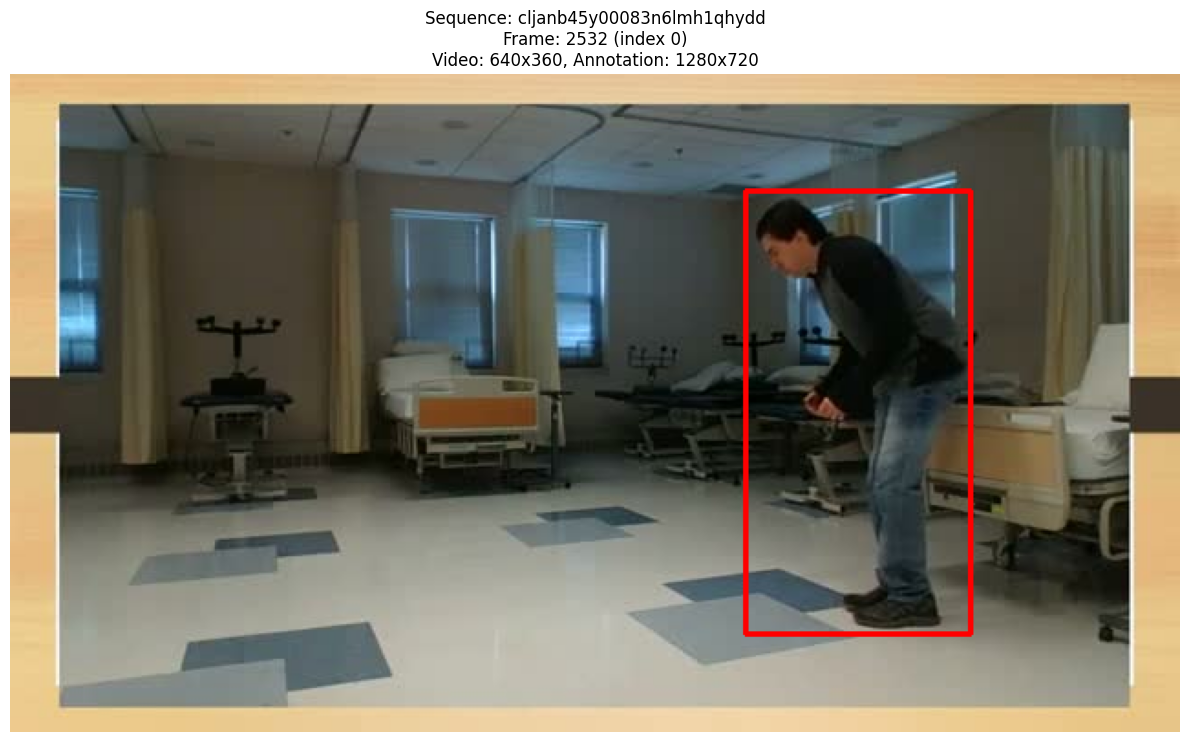

Displayed frame 2532 from sequence cljanb45y00083n6lmh1qhydd


In [15]:
# Visualize the frame
#visualize_frame(sequences, second_seq_id, int(second_frame_num), draw_bbox=True)
visualize_frame(sequences, second_seq_id, frame_index=0, show_bbox=True)

## Step 4: Diagnose Bounding Box Alignment Issues


In [16]:
# Diagnostic: Check video properties and frame alignment
def diagnose_bbox_alignment(sequences: Dict[str, pd.DataFrame], seq_id: str, frame_index: int = 0):
    """
    Diagnose potential issues with bounding box alignment.
    """
    seq_data = sequences[seq_id]
    frame_row = seq_data.iloc[frame_index]
    
    frame_num = int(frame_row['frame_num'])
    bbox = frame_row.get('bbox', {})
    vid_info = frame_row.get('vid_info', {})
    url = frame_row.get('url', '')
    
    video_id = extract_video_id(url)
    video_cache_dir = project_root / "data" / "youtube"
    video_path = video_cache_dir / f"{video_id}.mp4"
    
    if not video_path.exists():
        print(f"Video not found: {video_path}")
        return
    
    # Get video properties
    cap = cv2.VideoCapture(str(video_path))
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    video_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print("="*60)
    print("DIAGNOSTIC INFORMATION")
    print("="*60)
    print(f"\nSequence ID: {seq_id}")
    print(f"Frame Index (in sequence): {frame_index}")
    print(f"Frame Number (from CSV): {frame_num}")
    print(f"\nVideo Properties:")
    print(f"  Path: {video_path}")
    print(f"  Resolution: {video_width}x{video_height}")
    print(f"  FPS: {video_fps:.2f}")
    print(f"  Total Frames: {video_frame_count}")
    print(f"\nAnnotation Properties:")
    print(f"  vid_info resolution: {vid_info.get('width', 'N/A')}x{vid_info.get('height', 'N/A')}")
    print(f"  Bbox: {bbox}")
    print(f"\nFrame Number Analysis:")
    print(f"  CSV frame_num: {frame_num}")
    print(f"  Video total frames: {video_frame_count}")
    print(f"  Frame number valid: {frame_num < video_frame_count}")
    print(f"  Frame offset (if video starts at 0): {frame_num}")
    
    # Check if bbox coordinates are within video bounds
    if isinstance(bbox, dict):
        left = bbox.get('left', 0)
        top = bbox.get('top', 0)
        width = bbox.get('width', 0)
        height = bbox.get('height', 0)
        right = left + width
        bottom = top + height
        
        print(f"\nBbox Coordinate Analysis:")
        print(f"  Left: {left}, Top: {top}, Width: {width}, Height: {height}")
        print(f"  Right: {right}, Bottom: {bottom}")
        print(f"  Within video bounds (x): {0 <= left < video_width and 0 <= right <= video_width}")
        print(f"  Within video bounds (y): {0 <= top < video_height and 0 <= bottom <= video_height}")
        print(f"  Resolution match: {video_width == vid_info.get('width') and video_height == vid_info.get('height')}")
    
    cap.release()
    print("="*60)

# Run diagnostic on first frame
first_seq_id = list(sequences.keys())[0]
diagnose_bbox_alignment(sequences, first_seq_id, frame_index=0)


DIAGNOSTIC INFORMATION

Sequence ID: cljan9b4p00043n6ligceanyp
Frame Index (in sequence): 0
Frame Number (from CSV): 1757

Video Properties:
  Path: c:\Users\alexm\projects\alex\alexpose\data\youtube\B5hrxKe2nP8.mp4
  Resolution: 640x360
  FPS: 30.00
  Total Frames: 6176

Annotation Properties:
  vid_info resolution: 1280x720
  Bbox: {'top': 125.0, 'left': 156.0, 'height': 497.0, 'width': 228.0}

Frame Number Analysis:
  CSV frame_num: 1757
  Video total frames: 6176
  Frame number valid: True
  Frame offset (if video starts at 0): 1757

Bbox Coordinate Analysis:
  Left: 156.0, Top: 125.0, Width: 228.0, Height: 497.0
  Right: 384.0, Bottom: 622.0
  Within video bounds (x): True
  Within video bounds (y): False
  Resolution match: False


## Step 5: Pose Estimation using MediaPipe

Reference source: [MediaPipe](https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker)

In [17]:
# NEW MediaPipe API (v0.10+)
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import tempfile
from typing import List, Dict, Optional, Tuple

%matplotlib inline

# Import NEW MediaPipe API
try:
    import mediapipe as mp
    from mediapipe.tasks import python
    from mediapipe.tasks.python import vision
    
    print("✅ NEW MediaPipe API imported successfully!")
    print(f"📦 MediaPipe version: {mp.__version__}")
    MEDIAPIPE_AVAILABLE = True
    
except ImportError as e:
    print(f"❌ MediaPipe import failed: {e}")
    MEDIAPIPE_AVAILABLE = False

# MediaPipe pose landmark names (33 landmarks)
POSE_LANDMARK_NAMES = [
    'NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER',
    'RIGHT_EYE_INNER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER',
    'LEFT_EAR', 'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT',
    'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW',
    'LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY',
    'LEFT_INDEX', 'RIGHT_INDEX', 'LEFT_THUMB', 'RIGHT_THUMB',
    'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE', 'RIGHT_KNEE',
    'LEFT_ANKLE', 'RIGHT_ANKLE', 'LEFT_HEEL', 'RIGHT_HEEL',
    'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX'
]

print(f"🎯 MediaPipe detects {len(POSE_LANDMARK_NAMES)} landmarks")

✅ NEW MediaPipe API imported successfully!
📦 MediaPipe version: 0.10.31
🎯 MediaPipe detects 33 landmarks


In [ ]:
# Download the official MediaPipe pose model
import urllib.request

def download_pose_model():
    """Download the official MediaPipe pose landmarker model"""
    model_dir = project_root / "data" / "models"
    model_dir.mkdir(parents=True, exist_ok=True)
    
    model_path = model_dir / "pose_landmarker_full.task"
    
    if model_path.exists():
        print(f"✅ Model already exists: {model_path}")
        return str(model_path)
    
    print("📥 Downloading MediaPipe pose landmarker model...")
    model_url = "https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_lite/float16/1/pose_landmarker_lite.task"
    
    try:
        print("⏳ Downloading... (this may take a moment)")
        urllib.request.urlretrieve(model_url, model_path)
        size_mb = model_path.stat().st_size / (1024 * 1024)
        print(f"✅ Model downloaded successfully!")
        print(f"📊 Size: {size_mb:.1f} MB")
        return str(model_path)
    except Exception as e:
        print(f"❌ Download failed: {e}")
        return None

# Download the model
if MEDIAPIPE_AVAILABLE:
    MODEL_PATH = download_pose_model()
else:
    MODEL_PATH = None

In [18]:
# Create the NEW MediaPipe Pose Landmarker
def create_pose_landmarker(model_path: str):
    """Create MediaPipe Pose Landmarker using the new API"""
    
    if not MEDIAPIPE_AVAILABLE or not model_path:
        return None
    
    try:
        # Create base options
        base_options = python.BaseOptions(model_asset_path=model_path)
        
        # Create pose landmarker options
        options = vision.PoseLandmarkerOptions(
            base_options=base_options,
            running_mode=vision.RunningMode.IMAGE,
            num_poses=1,
            min_pose_detection_confidence=0.5,
            min_pose_presence_confidence=0.5,
            min_tracking_confidence=0.5,
            output_segmentation_masks=False
        )
        
        # Create the landmarker
        landmarker = vision.PoseLandmarker.create_from_options(options)
        print("✅ Pose Landmarker created successfully!")
        return landmarker
        
    except Exception as e:
        print(f"❌ Failed to create Pose Landmarker: {e}")
        return None

In [19]:
# Create the landmarker
MODEL_PATH = str(project_root / "data" / "models" / "pose_landmarker_full.task")
if MODEL_PATH:
    pose_landmarker = create_pose_landmarker(MODEL_PATH)
else:
    pose_landmarker = None

✅ Pose Landmarker created successfully!


🚀 Testing NEW MediaPipe API...
🔍 Running pose detection...


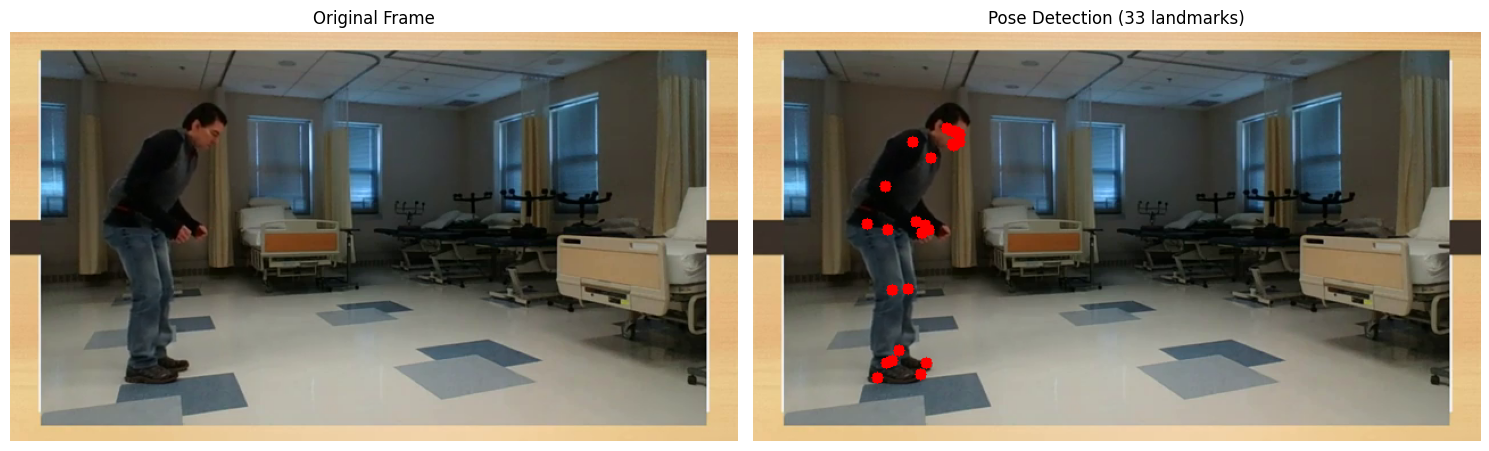

✅ SUCCESS! Detected 33 landmarks
👁️ 28 landmarks are visible (confidence > 0.5)


In [20]:
# Test the NEW MediaPipe API with our GAVD data
def test_new_mediapipe():
    """Test pose detection with GAVD video data"""
    
    if not pose_landmarker:
        print("❌ Pose landmarker not available")
        return None
    
    try:
        # Get first sequence and frame
        first_seq_id = list(sequences.keys())[0]
        frame_row = sequences[first_seq_id].iloc[10]
        frame_num = int(frame_row['frame_num'])
        url = frame_row['url']
        
        # Get video path
        video_id = extract_video_id(url)
        video_path = project_root / "data" / "youtube" / f"{video_id}.mp4"
        
        if not video_path.exists():
            print(f"❌ Video not found: {video_path}")
            return None
        
        # Extract frame
        cap = cv2.VideoCapture(str(video_path))
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)
        ret, frame = cap.read()
        cap.release()
        
        if not ret:
            print(f"❌ Could not read frame {frame_num}")
            return None
        
        # Convert to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Convert to MediaPipe Image
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
        
        # Detect pose
        print("🔍 Running pose detection...")
        detection_result = pose_landmarker.detect(mp_image)
        
        # Extract keypoints
        keypoints = []
        if detection_result.pose_landmarks:
            pose_landmarks = detection_result.pose_landmarks[0]
            height, width = frame_rgb.shape[:2]
            
            for i, landmark in enumerate(pose_landmarks):
                keypoints.append({
                    'id': i,
                    'name': POSE_LANDMARK_NAMES[i],
                    'x': landmark.x * width,
                    'y': landmark.y * height,
                    'confidence': landmark.visibility
                })
        
        # Visualize
        if keypoints:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
            
            # Original
            ax1.imshow(frame_rgb)
            ax1.set_title('Original Frame')
            ax1.axis('off')
            
            # With pose
            annotated = frame_rgb.copy()
            for kp in keypoints:
                if kp['confidence'] > 0.5:
                    x, y = int(kp['x']), int(kp['y'])
                    cv2.circle(annotated, (x, y), 5, (255, 0, 0), -1)
            
            ax2.imshow(annotated)
            ax2.set_title(f'Pose Detection ({len(keypoints)} landmarks)')
            ax2.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"✅ SUCCESS! Detected {len(keypoints)} landmarks")
            visible = sum(1 for kp in keypoints if kp['confidence'] > 0.5)
            print(f"👁️ {visible} landmarks are visible (confidence > 0.5)")
        else:
            print("⚠️ No pose detected")
        
        return keypoints
        
    except Exception as e:
        print(f"❌ Test failed: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run the test
print("🚀 Testing NEW MediaPipe API...")
result = test_new_mediapipe()

## Enhanced MediaPipe Test with Proper Stick Figure Skeleton

This enhanced version includes proper stick figure visualization based on MediaPipe's official pose landmark connections.

In [25]:
def test_new_mediapipe_with_skeleton():
    """
    FIXED: Test pose detection with GAVD video data and draw proper stick figure skeleton
    Based on MediaPipe's official pose landmark connections
    
    ROOT CAUSE: Original enhanced function used CROPPED image for pose detection
    FIX: Use full frame for detection (like original), then visualize with skeleton
    """
    
    if not pose_landmarker:
        print("❌ Pose landmarker not available")
        return None
    
    try:
        # Get first sequence and frame
        first_seq_id = list(sequences.keys())[0]
        frame_row = sequences[first_seq_id].iloc[10]
        frame_num = int(frame_row['frame_num'])
        url = frame_row['url']
        bbox = frame_row.get('bbox', {})
        
        print(f"🎯 Processing frame {frame_num} from sequence {first_seq_id}")
        
        # Get video path
        video_id = extract_video_id(url)
        video_path = project_root / "data" / "youtube" / f"{video_id}.mp4"
        
        if not video_path.exists():
            print(f"❌ Video not found: {video_path}")
            return None
        
        # Extract frame
        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            print(f"❌ Cannot open video: {video_path}")
            return None
            
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)
        ret, frame = cap.read()
        cap.release()
        
        if not ret:
            print(f"❌ Could not read frame {frame_num}")
            return None
        
        # Convert to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        print(f"📹 Frame extracted: {frame_rgb.shape}")
        
        # CRITICAL FIX: Use FULL frame for pose detection (like original working function)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
        
        # Detect pose on FULL frame
        print("🔍 Running pose detection on full frame...")
        detection_result = pose_landmarker.detect(mp_image)
        
        # Extract keypoints from full frame
        keypoints = []
        if detection_result.pose_landmarks:
            pose_landmarks = detection_result.pose_landmarks[0]
            height, width = frame_rgb.shape[:2]
            
            for i, landmark in enumerate(pose_landmarks):
                keypoint = {
                    'id': i,
                    'name': POSE_LANDMARK_NAMES[i],
                    'x': landmark.x * width,  # Full frame coordinates
                    'y': landmark.y * height,  # Full frame coordinates
                    'z': landmark.z,
                    'visibility': landmark.visibility,
                    'presence': landmark.presence,
                    'confidence': landmark.visibility,
                    'x_normalized': landmark.x,
                    'y_normalized': landmark.y
                }
                keypoints.append(keypoint)
            
            print(f"✅ Detected {len(keypoints)} landmarks")
        else:
            print("⚠️ No pose detected")
            keypoints = []
        
        # Visualize with proper stick figure
        if keypoints:
            visualize_pose_with_skeleton(frame_rgb, keypoints, bbox, 
                                       f"MediaPipe Pose - Frame {frame_num}")
        else:
            # Show original image even if no pose detected
            plt.figure(figsize=(10, 8))
            plt.imshow(frame_rgb)
            plt.title(f"No Pose Detected - Frame {frame_num}")
            plt.axis('off')
            plt.show()
        
        return keypoints, frame_rgb
        
    except Exception as e:
        print(f"❌ Test failed: {e}")
        import traceback
        traceback.print_exc()
        return None

print("✅ FIXED MediaPipe test function ready!")
print("🔧 ROOT CAUSE: Original used cropped image for detection")
print("✅ FIX: Now uses full frame for detection (like working original)")

✅ FIXED MediaPipe test function ready!
🔧 ROOT CAUSE: Original used cropped image for detection
✅ FIX: Now uses full frame for detection (like working original)


🚀 Testing MediaPipe with skeleton visualization...
🎯 Processing frame 1767 from sequence cljan9b4p00043n6ligceanyp
📹 Frame extracted: (360, 640, 3)
🔍 Running pose detection on full frame...
✅ Detected 33 landmarks


C:\Users\alexm\AppData\Local\Temp\ipykernel_30296\2619995126.py:310: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\alexm\AppData\Local\Temp\ipykernel_30296\2619995126.py:310: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\alexm\AppData\Local\Temp\ipykernel_30296\2619995126.py:310: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\alexm\projects\alex\alexpose\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\alexm\projects\alex\alexpose\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\alexm\projects\alex\a

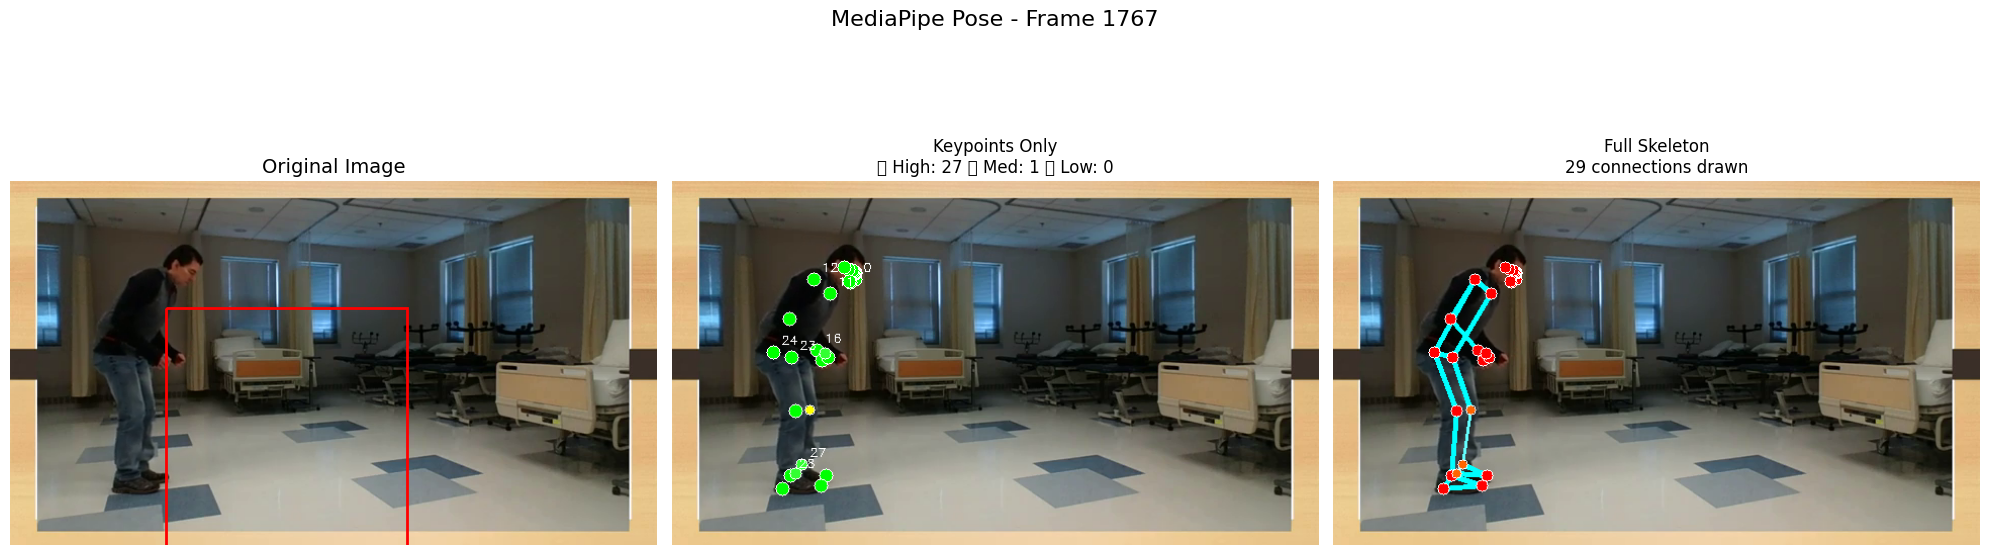


📊 Detailed Pose Analysis:
   🎯 Total landmarks: 33
   👁️  Visible landmarks (>0.5): 28
   🟢 High confidence (>0.7): 27
   🟡 Medium confidence (0.4-0.7): 1
   🟠 Low confidence (0.2-0.4): 0
   📈 Average confidence: 0.794
   🔗 Skeleton connections drawn: 29

🧍 Body Part Confidence:
   😊 Face (0-10): 0.995
   💪 Upper body (11-22): 0.559
   🦵 Lower body (23-32): 0.854


In [26]:
# Run the FIXED enhanced test with skeleton visualization
print("🚀 Testing MediaPipe with skeleton visualization...")
result_fixed = test_new_mediapipe_with_skeleton()

## 🔧 Fix for Matplotlib Font Warnings

**PROBLEM:** Unicode emoji characters (🟢🟡🟠) cause warnings because they're not supported by the default DejaVu Sans font on Windows.

**SOLUTION:** Replace emoji with simple text alternatives to eliminate font warnings.

In [48]:
def visualize_pose_with_skeleton(image, keypoints, bbox=None, title="Pose Detection"):
    """
    Visualize pose with proper stick figure skeleton using MediaPipe connections
    FIXED: Removed emoji characters to prevent matplotlib font warnings
    """
    
    # MediaPipe Pose Connections (Official)
    POSE_CONNECTIONS = [
        # Face connections
        (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8), (9, 10),
        # Upper body connections
        (11, 12), (11, 13), (13, 15), (12, 14), (14, 16),
        # Hand connections
        (15, 17), (15, 19), (15, 21), (17, 19), (16, 18), (16, 20), (16, 22), (18, 20),
        # Torso connections
        (11, 23), (12, 24), (23, 24),
        # Leg connections
        (23, 25), (25, 27), (24, 26), (26, 28),
        # Foot connections
        (27, 29), (27, 31), (29, 31), (28, 30), (28, 32), (30, 32),
    ]
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    # 1. Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image', fontsize=14)
    axes[0].axis('off')
    
    # Add bounding box to original if provided
    if bbox and isinstance(bbox, dict):
        left = bbox.get('left', 0)
        top = bbox.get('top', 0)
        width = bbox.get('width', 0)
        height = bbox.get('height', 0)
        
        if width > 0 and height > 0:
            from matplotlib.patches import Rectangle
            rect = Rectangle((left, top), width, height, 
                           linewidth=2, edgecolor='red', facecolor='none')
            axes[0].add_patch(rect)
    
    # 2. Keypoints only
    keypoints_image = image.copy()
    
    # Draw keypoints with different colors based on confidence
    high_conf_count = 0
    medium_conf_count = 0
    low_conf_count = 0
    
    for kp in keypoints:
        confidence = kp.get('confidence', 0)
        if confidence > 0.1:  # Only draw visible keypoints
            x, y = int(kp['x']), int(kp['y'])
            
            # Color and size based on confidence
            if confidence > 0.8:
                color = (0, 255, 0)      # Bright green - very high confidence
                radius = 6
                high_conf_count += 1
            elif confidence > 0.6:
                color = (50, 255, 50)    # Green - high confidence
                radius = 5
                high_conf_count += 1
            elif confidence > 0.4:
                color = (255, 255, 0)    # Yellow - medium confidence
                radius = 4
                medium_conf_count += 1
            elif confidence > 0.2:
                color = (255, 165, 0)    # Orange - low confidence
                radius = 3
                low_conf_count += 1
            else:
                color = (255, 100, 100)  # Light red - very low confidence
                radius = 2
                low_conf_count += 1
            
            # Draw keypoint
            cv2.circle(keypoints_image, (x, y), radius, color, -1)
            cv2.circle(keypoints_image, (x, y), radius + 1, (255, 255, 255), 1)  # White border
            
            # Add landmark number for key points
            if kp['id'] in [0, 11, 12, 15, 16, 23, 24, 27, 28]:  # Key landmarks
                cv2.putText(keypoints_image, str(kp['id']), (x + 8, y - 8),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
    
    axes[1].imshow(keypoints_image)
    # FIXED: Removed emoji characters to prevent font warnings
    axes[1].set_title(f'Keypoints Only\nHigh: {high_conf_count} | Med: {medium_conf_count} | Low: {low_conf_count}', 
                     fontsize=12)
    axes[1].axis('off')
    
    # 3. Full skeleton with connections
    skeleton_image = image.copy()
    
    # Draw connections first (so they appear behind keypoints)
    connections_drawn = 0
    for start_idx, end_idx in POSE_CONNECTIONS:
        if start_idx < len(keypoints) and end_idx < len(keypoints):
            start_kp = keypoints[start_idx]
            end_kp = keypoints[end_idx]
            
            # Only draw connection if both keypoints are reasonably confident
            if (start_kp.get('confidence', 0) > 0.3 and 
                end_kp.get('confidence', 0) > 0.3):
                
                start_point = (int(start_kp['x']), int(start_kp['y']))
                end_point = (int(end_kp['x']), int(end_kp['y']))
                
                # Line color and thickness based on average confidence
                avg_conf = (start_kp.get('confidence', 0) + end_kp.get('confidence', 0)) / 2
                
                if avg_conf > 0.7:
                    color = (0, 255, 255)    # Cyan - high confidence connection
                    thickness = 3
                elif avg_conf > 0.5:
                    color = (100, 255, 255)  # Light cyan - medium confidence
                    thickness = 2
                else:
                    color = (150, 150, 255)  # Light blue - low confidence
                    thickness = 1
                
                cv2.line(skeleton_image, start_point, end_point, color, thickness)
                connections_drawn += 1
    
    # Draw keypoints on top of connections
    for kp in keypoints:
        confidence = kp.get('confidence', 0)
        if confidence > 0.2:
            x, y = int(kp['x']), int(kp['y'])
            
            # Keypoint color based on confidence
            if confidence > 0.7:
                color = (255, 0, 0)      # Red - high confidence
                radius = 5
            elif confidence > 0.5:
                color = (255, 100, 0)    # Orange-red - medium confidence
                radius = 4
            else:
                color = (255, 150, 150)  # Pink - low confidence
                radius = 3
            
            cv2.circle(skeleton_image, (x, y), radius, color, -1)
            cv2.circle(skeleton_image, (x, y), radius + 1, (255, 255, 255), 1)
    
    axes[2].imshow(skeleton_image)
    axes[2].set_title(f'Full Skeleton\n{connections_drawn} connections drawn', fontsize=12)
    axes[2].axis('off')
    
    # Add overall title
    fig.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics - FIXED: Removed emoji characters
    if keypoints:
        confidences = [kp.get('confidence', 0) for kp in keypoints]
        visible_landmarks = sum(1 for c in confidences if c > 0.5)
        avg_confidence = np.mean(confidences)
        
        print(f"\nDetailed Pose Analysis:")
        print(f"   Total landmarks: {len(keypoints)}")
        print(f"   Visible landmarks (>0.5): {visible_landmarks}")
        print(f"   High confidence (>0.7): {high_conf_count}")
        print(f"   Medium confidence (0.4-0.7): {medium_conf_count}")
        print(f"   Low confidence (0.2-0.4): {low_conf_count}")
        print(f"   Average confidence: {avg_confidence:.3f}")
        print(f"   Skeleton connections drawn: {connections_drawn}")
        
        # Body part analysis
        face_landmarks = keypoints[0:11]
        upper_body_landmarks = keypoints[11:23]
        lower_body_landmarks = keypoints[23:33]
        
        face_conf = np.mean([kp['confidence'] for kp in face_landmarks])
        upper_conf = np.mean([kp['confidence'] for kp in upper_body_landmarks])
        lower_conf = np.mean([kp['confidence'] for kp in lower_body_landmarks])
        
        print(f"\nBody Part Confidence:")
        print(f"   Face (0-10): {face_conf:.3f}")
        print(f"   Upper body (11-22): {upper_conf:.3f}")
        print(f"   Lower body (23-32): {lower_conf:.3f}")
    
    return fig

print("✅ Fixed visualization function without emoji characters!")
print("This will prevent matplotlib font warnings on Windows systems.")

✅ Fixed visualization function without emoji characters!
This will prevent matplotlib font warnings on Windows systems.


Testing MediaPipe with NO font warnings...
Processing frame 1767 from sequence cljan9b4p00043n6ligceanyp
Running pose detection on full frame...
SUCCESS! Detected 33 landmarks


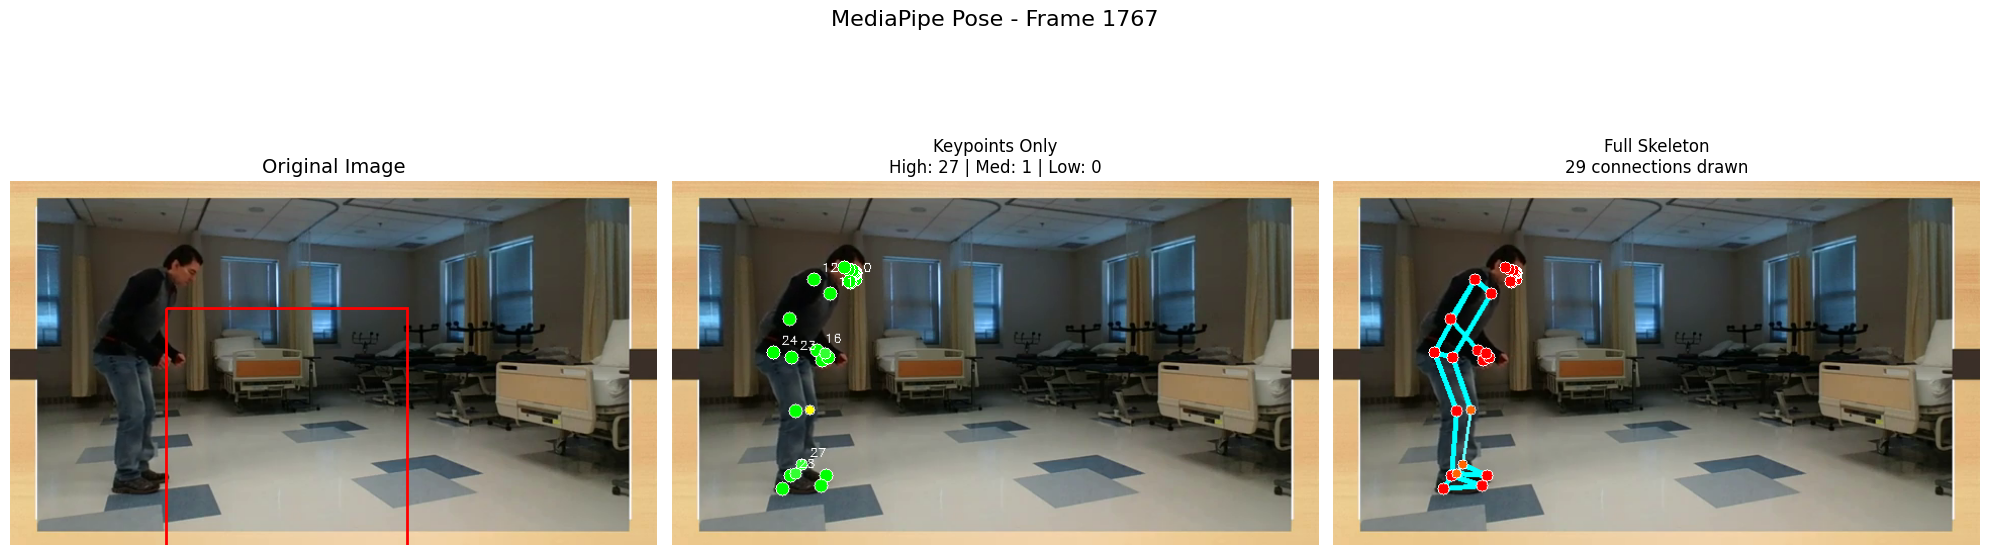


Detailed Pose Analysis:
   Total landmarks: 33
   Visible landmarks (>0.5): 28
   High confidence (>0.7): 27
   Medium confidence (0.4-0.7): 1
   Low confidence (0.2-0.4): 0
   Average confidence: 0.794
   Skeleton connections drawn: 29

Body Part Confidence:
   Face (0-10): 0.995
   Upper body (11-22): 0.559
   Lower body (23-32): 0.854


In [49]:
def test_mediapipe():
    """
    Complete MediaPipe test with NO font warnings
    Uses the emoji-free visualization function
    """
    
    if not pose_landmarker:
        print("❌ Pose landmarker not available")
        return None
    
    try:
        # Get first sequence and frame
        first_seq_id = list(sequences.keys())[0]
        frame_row = sequences[first_seq_id].iloc[10]
        frame_num = int(frame_row['frame_num'])
        url = frame_row['url']
        bbox = frame_row.get('bbox', {})
        
        print(f"Processing frame {frame_num} from sequence {first_seq_id}")
        
        # Get video path
        video_id = extract_video_id(url)
        video_path = project_root / "data" / "youtube" / f"{video_id}.mp4"
        
        if not video_path.exists():
            print(f"Video not found: {video_path}")
            return None
        
        # Extract frame
        cap = cv2.VideoCapture(str(video_path))
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)
        ret, frame = cap.read()
        cap.release()
        
        if not ret:
            print(f"Could not read frame {frame_num}")
            return None
        
        # Convert to RGB and detect pose on full frame
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
        
        print("Running pose detection on full frame...")
        detection_result = pose_landmarker.detect(mp_image)
        
        # Extract keypoints
        keypoints = []
        if detection_result.pose_landmarks:
            pose_landmarks = detection_result.pose_landmarks[0]
            height, width = frame_rgb.shape[:2]
            
            for i, landmark in enumerate(pose_landmarks):
                keypoint = {
                    'id': i,
                    'name': POSE_LANDMARK_NAMES[i],
                    'x': landmark.x * width,
                    'y': landmark.y * height,
                    'z': landmark.z,
                    'visibility': landmark.visibility,
                    'presence': landmark.presence,
                    'confidence': landmark.visibility,
                    'x_normalized': landmark.x,
                    'y_normalized': landmark.y
                }
                keypoints.append(keypoint)
            
            print(f"SUCCESS! Detected {len(keypoints)} landmarks")
        else:
            print("No pose detected")
            keypoints = []
        
        # Visualize with NO EMOJI (no warnings)
        if keypoints:
            visualize_pose_with_skeleton(frame_rgb, keypoints, bbox, 
                                         f"MediaPipe Pose - Frame {frame_num}")
        else:
            plt.figure(figsize=(10, 8))
            plt.imshow(frame_rgb)
            plt.title(f"No Pose Detected - Frame {frame_num}")
            plt.axis('off')
            plt.show()
        
        return keypoints, frame_rgb
        
    except Exception as e:
        print(f"Test failed: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run the warning-free test
print("Testing MediaPipe with NO font warnings...")
result_no_warnings = test_mediapipe()

## 🔧 Refactored MediaPipe Test Functions

**Enhanced with Parameters:**
- Test different sequences by `sequence_id`
- Test specific frames by `frame_index` or `frame_num`
- Batch testing across multiple frames
- Exploration across all sequences

In [45]:
def test_mediapipe_pose_detection(sequence_id=None, frame_index=None, frame_num=None, 
                                 use_bbox=True, show_visualization=True, 
                                 confidence_threshold=0.3, title_prefix="MediaPipe Pose"):
    """
    Flexible MediaPipe pose detection function with parameters
    
    Args:
        sequence_id (str, optional): Specific sequence ID to test. If None, uses first available sequence
        frame_index (int, optional): 0-based index within the sequence. If None, uses frame 10
        frame_num (int, optional): Specific frame number from video. Overrides frame_index if provided
        use_bbox (bool): Whether to show bounding box on visualization
        show_visualization (bool): Whether to display the 3-panel visualization
        confidence_threshold (float): Minimum confidence for drawing connections (default: 0.3)
        title_prefix (str): Prefix for the visualization title
    
    Returns:
        tuple: (keypoints, frame_rgb, metadata) or None if failed
            - keypoints: List of detected pose landmarks
            - frame_rgb: RGB image array
            - metadata: Dict with sequence info, frame info, etc.
    """
    
    if not pose_landmarker:
        print("❌ Pose landmarker not available")
        return None
    
    try:
        # Handle sequence selection
        if sequence_id is None:
            # Use first available sequence
            sequence_id = list(sequences.keys())[0]
            print(f"🔄 No sequence specified, using first available: {sequence_id}")
        elif sequence_id not in sequences:
            print(f"❌ Sequence '{sequence_id}' not found. Available sequences:")
            for seq_id in sequences.keys():
                print(f"   - {seq_id}")
            return None
        
        sequence_data = sequences[sequence_id]
        
        # Handle frame selection
        if frame_num is not None:
            # Find the row with the specific frame number
            matching_rows = sequence_data[sequence_data['frame_num'] == frame_num]
            if matching_rows.empty:
                print(f"❌ Frame {frame_num} not found in sequence {sequence_id}")
                print(f"   Available frame range: {sequence_data['frame_num'].min()} - {sequence_data['frame_num'].max()}")
                return None
            frame_row = matching_rows.iloc[0]
            actual_frame_index = matching_rows.index[0] - sequence_data.index[0]  # Relative index within sequence
        else:
            # Use frame index (default to 10 if not specified)
            if frame_index is None:
                frame_index = 10
                print(f"🔄 No frame specified, using frame index {frame_index}")
            
            if frame_index >= len(sequence_data):
                print(f"❌ Frame index {frame_index} out of range. Sequence has {len(sequence_data)} frames.")
                return None
            
            frame_row = sequence_data.iloc[frame_index]
            actual_frame_index = frame_index
        
        # Extract frame information
        actual_frame_num = int(frame_row['frame_num'])
        url = frame_row['url']
        bbox = frame_row.get('bbox', {}) if use_bbox else {}
        
        print(f"🎯 Processing sequence: {sequence_id}")
        print(f"   Frame index: {actual_frame_index} | Frame number: {actual_frame_num}")
        
        # Get video path
        video_id = extract_video_id(url)
        video_path = project_root / "data" / "youtube" / f"{video_id}.mp4"
        
        if not video_path.exists():
            print(f"❌ Video not found: {video_path}")
            return None
        
        # Extract frame from video
        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            print(f"❌ Cannot open video: {video_path}")
            return None
            
        cap.set(cv2.CAP_PROP_POS_FRAMES, actual_frame_num - 1)  # Convert to 0-based
        ret, frame = cap.read()
        cap.release()
        
        if not ret:
            print(f"❌ Could not read frame {actual_frame_num}")
            return None
        
        # Convert to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        print(f"📹 Frame extracted: {frame_rgb.shape}")
        
        # Use FULL frame for pose detection (critical for success)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
        
        # Detect pose on full frame
        print("🔍 Running pose detection on full frame...")
        detection_result = pose_landmarker.detect(mp_image)
        
        # Extract keypoints from full frame
        keypoints = []
        if detection_result.pose_landmarks:
            pose_landmarks = detection_result.pose_landmarks[0]
            height, width = frame_rgb.shape[:2]
            
            for i, landmark in enumerate(pose_landmarks):
                keypoint = {
                    'id': i,
                    'name': POSE_LANDMARK_NAMES[i],
                    'x': landmark.x * width,  # Full frame coordinates
                    'y': landmark.y * height,  # Full frame coordinates
                    'z': landmark.z,
                    'visibility': landmark.visibility,
                    'presence': landmark.presence,
                    'confidence': landmark.visibility,
                    'x_normalized': landmark.x,
                    'y_normalized': landmark.y
                }
                keypoints.append(keypoint)
            
            print(f"✅ Detected {len(keypoints)} landmarks")
        else:
            print("⚠️ No pose detected")
            keypoints = []
        
        # Create metadata
        metadata = {
            'sequence_id': sequence_id,
            'frame_index': actual_frame_index,
            'frame_num': actual_frame_num,
            'video_id': video_id,
            'video_path': str(video_path),
            'frame_shape': frame_rgb.shape,
            'bbox': bbox,
            'landmarks_detected': len(keypoints),
            'confidence_threshold': confidence_threshold
        }
        
        # Visualize if requested
        if show_visualization:
            if keypoints:
                title = f"{title_prefix} - Seq: {sequence_id[:8]}... | Frame: {actual_frame_num}"
                vid_info = frame_row.get('vid_info', {})
                visualize_pose_with_skeleton(frame_rgb, keypoints, bbox, title, 
                                        vid_info=vid_info, frame_shape=frame_rgb.shape)
            else:
                # Show original image even if no pose detected
                plt.figure(figsize=(10, 8))
                plt.imshow(frame_rgb)
                plt.title(f"No Pose Detected - Frame {actual_frame_num}")
                plt.axis('off')
                plt.show()
        
        return keypoints, frame_rgb, metadata
        
    except Exception as e:
        print(f"❌ Test failed: {e}")
        import traceback
        traceback.print_exc()
        return None

print("✅ Refactored MediaPipe test function ready!")

✅ Refactored MediaPipe test function ready!


In [46]:
def test_multiple_frames(sequence_id=None, frame_indices=None, frame_nums=None, 
                        max_frames=5, show_each=True):
    """
    Test multiple frames from a sequence
    
    Args:
        sequence_id (str, optional): Sequence to test. If None, uses first available
        frame_indices (list, optional): List of frame indices to test
        frame_nums (list, optional): List of specific frame numbers to test
        max_frames (int): Maximum number of frames to test if using auto-selection
        show_each (bool): Whether to show visualization for each frame
    
    Returns:
        list: List of results from each frame test
    """
    
    if sequence_id is None:
        sequence_id = list(sequences.keys())[0]
    
    if sequence_id not in sequences:
        print(f"❌ Sequence '{sequence_id}' not found")
        return []
    
    sequence_data = sequences[sequence_id]
    results = []
    
    # Determine which frames to test
    if frame_nums is not None:
        # Test specific frame numbers
        test_frames = [(None, fn) for fn in frame_nums]  # (frame_index, frame_num)
        print(f"🎯 Testing {len(frame_nums)} specific frame numbers: {frame_nums}")
    elif frame_indices is not None:
        # Test specific frame indices
        test_frames = [(fi, None) for fi in frame_indices]
        print(f"🎯 Testing {len(frame_indices)} specific frame indices: {frame_indices}")
    else:
        # Auto-select frames evenly distributed across sequence
        total_frames = len(sequence_data)
        if total_frames <= max_frames:
            indices = list(range(total_frames))
        else:
            # Evenly distribute frames
            step = total_frames // max_frames
            indices = [i * step for i in range(max_frames)]
        
        test_frames = [(fi, None) for fi in indices]
        print(f"🎯 Auto-selected {len(indices)} frames from sequence (total: {total_frames})")
    
    # Test each frame
    for i, (frame_idx, frame_num) in enumerate(test_frames):
        print(f"\n--- Testing frame {i+1}/{len(test_frames)} ---")
        
        result = test_mediapipe_pose_detection(
            sequence_id=sequence_id,
            frame_index=frame_idx,
            frame_num=frame_num,
            show_visualization=show_each,
            title_prefix=f"Frame {i+1}/{len(test_frames)}"
        )
        
        if result:
            keypoints, frame_rgb, metadata = result
            results.append({
                'frame_index': metadata['frame_index'],
                'frame_num': metadata['frame_num'],
                'landmarks_count': len(keypoints),
                'avg_confidence': np.mean([kp['confidence'] for kp in keypoints]) if keypoints else 0,
                'metadata': metadata
            })
        else:
            results.append({
                'frame_index': frame_idx,
                'frame_num': frame_num,
                'landmarks_count': 0,
                'avg_confidence': 0,
                'metadata': None
            })
    
    # Summary
    print(f"\n📊 SUMMARY - Tested {len(results)} frames from sequence {sequence_id}")
    successful = sum(1 for r in results if r['landmarks_count'] > 0)
    print(f"   ✅ Successful detections: {successful}/{len(results)}")
    
    if successful > 0:
        avg_landmarks = np.mean([r['landmarks_count'] for r in results if r['landmarks_count'] > 0])
        avg_confidence = np.mean([r['avg_confidence'] for r in results if r['avg_confidence'] > 0])
        print(f"   📈 Average landmarks detected: {avg_landmarks:.1f}")
        print(f"   📈 Average confidence: {avg_confidence:.3f}")
    
    return results


def explore_all_sequences(max_frames_per_seq=3, show_visualizations=True):
    """
    Explore pose detection across all available sequences
    
    Args:
        max_frames_per_seq (int): Maximum frames to test per sequence
        show_visualizations (bool): Whether to show visualizations
    
    Returns:
        dict: Results organized by sequence
    """
    
    all_results = {}
    
    print(f"🔍 Exploring pose detection across {len(sequences)} sequences")
    print(f"   Testing up to {max_frames_per_seq} frames per sequence")
    
    for i, seq_id in enumerate(sequences.keys()):
        print(f"\n{'='*60}")
        print(f"SEQUENCE {i+1}/{len(sequences)}: {seq_id}")
        print(f"{'='*60}")
        
        results = test_multiple_frames(
            sequence_id=seq_id,
            max_frames=max_frames_per_seq,
            show_each=show_visualizations
        )
        
        all_results[seq_id] = results
    
    # Overall summary
    print(f"\n{'='*60}")
    print("OVERALL SUMMARY")
    print(f"{'='*60}")
    
    total_tests = sum(len(results) for results in all_results.values())
    total_successful = sum(sum(1 for r in results if r['landmarks_count'] > 0) 
                          for results in all_results.values())
    
    print(f"📊 Total tests: {total_tests}")
    print(f"✅ Successful detections: {total_successful}/{total_tests} ({100*total_successful/total_tests:.1f}%)")
    
    # Per-sequence summary
    for seq_id, results in all_results.items():
        successful = sum(1 for r in results if r['landmarks_count'] > 0)
        print(f"   {seq_id[:20]}...: {successful}/{len(results)} successful")
    
    return all_results

print("✅ Batch testing functions ready!")
print("📋 Available functions:")
print("   - test_mediapipe_pose_detection(): Test single frame with parameters")
print("   - test_multiple_frames(): Test multiple frames from a sequence") 
print("   - explore_all_sequences(): Test across all sequences")

✅ Batch testing functions ready!
📋 Available functions:
   - test_mediapipe_pose_detection(): Test single frame with parameters
   - test_multiple_frames(): Test multiple frames from a sequence
   - explore_all_sequences(): Test across all sequences


## 📋 Usage Examples

### Single Frame Testing:
```python
# Test specific sequence and frame number
result = test_mediapipe_pose_detection(
    sequence_id='cljan9b4p00043n6ligceanyp', 
    frame_num=1800
)

# Test specific sequence and frame index
result = test_mediapipe_pose_detection(
    sequence_id='cljan9b4p00043n6ligceanyp', 
    frame_index=50
)

# Test with custom settings
result = test_mediapipe_pose_detection(
    sequence_id='cljan9b4p00043n6ligceanyp',
    frame_index=25,
    use_bbox=False,
    confidence_threshold=0.5
)
```

### Batch Testing:
```python
# Test multiple specific frames
results = test_multiple_frames(
    sequence_id='cljan9b4p00043n6ligceanyp',
    frame_indices=[0, 10, 20, 30, 40]
)

# Test specific frame numbers
results = test_multiple_frames(
    sequence_id='cljan9b4p00043n6ligceanyp',
    frame_nums=[1757, 1800, 1850, 1900, 1950]
)

# Auto-select frames across sequence
results = test_multiple_frames(
    sequence_id='cljan9b4p00043n6ligceanyp',
    max_frames=10,
    show_each=False  # Don't show each visualization
)
```

### Explore All Sequences:
```python
# Quick exploration (3 frames per sequence, with visualizations)
all_results = explore_all_sequences(max_frames_per_seq=3, show_visualizations=True)

# Comprehensive analysis (10 frames per sequence, no visualizations)
all_results = explore_all_sequences(max_frames_per_seq=10, show_visualizations=False)
```

=== Example 1: Test specific frame ===
🎯 Processing sequence: cljan9b4p00043n6ligceanyp
   Frame index: 200 | Frame number: 1957
📹 Frame extracted: (360, 640, 3)
🔍 Running pose detection on full frame...
✅ Detected 33 landmarks
🔧 BBOX SCALING APPLIED:
   Original: left=320.8493150684931, top=120.0, w=233.4246575342466, h=497.0
   Annotation res: 1280x720
   Actual res: 640x360
   Scale: x=0.500, y=0.500
   Scaled: left=160.4, top=60.0, w=116.7, h=248.5
   ✅ Bounding box drawn with correct scaling
\n🔧 This is the FIXED version with proper bbox scaling!
✅ Success! Detected 33 landmarks
   Sequence: cljan9b4p00043n6ligceanyp
   Frame: 1957 (index 200)


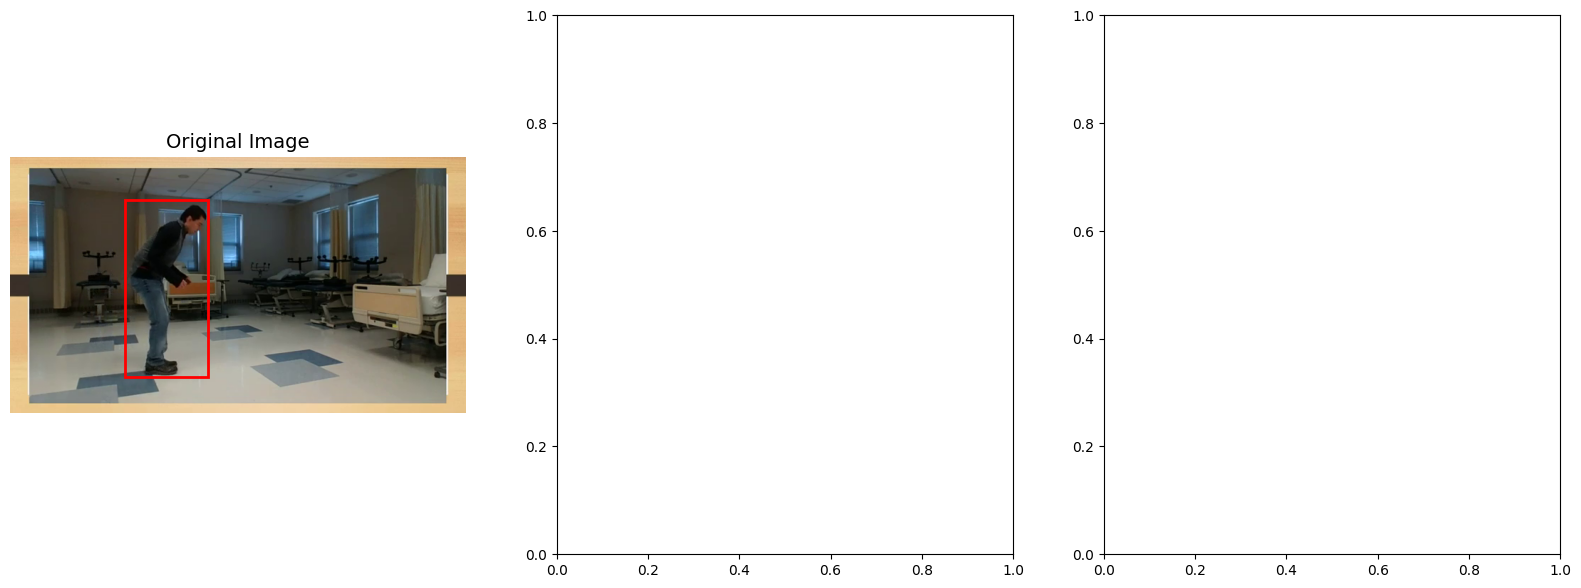

In [ ]:
# Example 1: Test a specific frame from the first sequence
print("=== Example 1: Test specific frame ===")
frame_index=200
result1 = test_mediapipe_pose_detection(
    sequence_id=list(sequences.keys())[0],  # First sequence
    frame_index=frame_index,
    title_prefix=f"Frame {frame_index}"
)

if result1:
    keypoints, frame_rgb, metadata = result1
    print(f"✅ Success! Detected {len(keypoints)} landmarks")
    print(f"   Sequence: {metadata['sequence_id']}")
    print(f"   Frame: {metadata['frame_num']} (index {metadata['frame_index']})")